In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
import scipy.stats
#%load_ext line_profiler
import time
import Cython
%load_ext Cython
import mcmc
%load_ext mcmc
%mcmc notebook

Autograd not available; using standard numpy.


In [51]:
n_pts = 6
ls = 0.04
seed = 123
np.random.seed(seed)
noise_variance = 1e-2

In [25]:

# for now collocate on a basic grid (this is not efficient)
x, y = np.mgrid[0:1:n_pts*1j, 0:1:n_pts*1j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_interior = np.c_[x[~on_bdy], y[~on_bdy]]

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

In [26]:
def cube_root(arr):
    arr = np.asarray(arr)
    ret = np.empty_like(arr)
    ret[arr >= 0] = arr[arr > 0]**(1./3)
    ret[arr < 0] = - np.abs(arr[arr < 0])**(1./3)
    return ret

# Calculation of Importance Distn

In [27]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [28]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [29]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [30]:
def retry(fun, tries, success_condition=None, debug=True):
    for i in xrange(tries):
        try:
            res = fun()
        except Exception as ex:
            if debug: 
                print('Attempt {} failed with exception {}'.format(i, ex))
            continue
        
        if success_condition is not None and success_condition(res):
            return res
        else:
            return res
        if debug:
            print('Attempt {} failed'.format(i))
    raise Exception('Failed to find solution in {} tries'.format(tries))
    
meshes = {}
fn_spaces = {}
bc_store = {}
def find_solutions(delta, mesh_points, initial_guesses=None, max_solutions=3, stop_on_divergence=False):
    # reuse mesh if we can
    if mesh_points in meshes:
        mesh = meshes[mesh_points]
        V = fn_spaces[mesh_points]
        bcs = bc_store[mesh_points]
    else:
        mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
        size = dolfin.MPI.size(dolfin.mpi_comm_world())
        if size > 1:
            nrefine = math.log(size, 4)
            if int(nrefine) != nrefine:
                print("Need to have processors a power of 4, as each refinement multiplies work by 4")
                assert False

            for i in range(int(nrefine) + 3):
                mesh = dolfin.refine(mesh, redistribute=False)
        meshes[mesh_points] = mesh

        V = dolfin.FunctionSpace(mesh, "CG", 1)
        fn_spaces[mesh_points] = V
        

        bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
               dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]
        bc_store[mesh_points] = bcs
    Vdim = V.dim()
    #if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
    #    print "Degrees of freedom: ", Vdim
    #    print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(delta)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in xrange(max_solutions):
        if initial_guesses is not None and len(initial_guesses) > i:
            u.assign(initial_guesses[i])
        dolfin.PETScOptions.set("snes_atol", natol)
        try:
            solver.solve(problem, u.vector())
        except Exception as ex:
            if stop_on_divergence:
                break
            else:
                raise
            
        roots.append(dolfin.Function(u, name="Solution"))

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots

In [31]:
def compute_latent(points, delta, solutions):
    # it is most convenient to compute the latent variables as the cube of the values at the points (i.e. at A_2),
    # since this means we don't have to fuss about with gradients.
    res = np.empty((points.shape[0], len(solutions)))
    for i in xrange(len(solutions)):
        res[:,i] = np.vectorize(solutions[i])(points[:,0], points[:,1])
    return -res**3 / delta

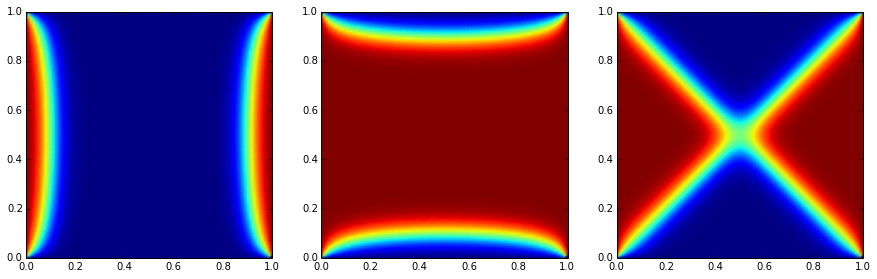

In [32]:
delta = 0.04
true_solutions = find_solutions(delta, 100, max_solutions=3, stop_on_divergence=False)
plt.figure(figsize=(15,5))
for ix, solution in enumerate(true_solutions):
    plt.subplot(1,3,ix)
    plot(solution)
    plt.gcf().patch.set_alpha(0.0)

In [33]:
data_x, data_y = np.mgrid[0:1:6j, 0:1:6j]
data_x = data_x.ravel(); data_y = data_y.ravel()
data_pts = np.c_[data_x, data_y]
data_pts = data_pts[(data_x > 0) & (data_x < 1) & (data_y > 0) & (data_y < 1)]
true_solution_values = np.vectorize(true_solutions[0])(data_pts[:,0], data_pts[:,1])

true_solution_values = true_solution_values + np.random.normal(0, noise_variance)
true_obs = (data_pts, true_solution_values)

A sensible range looks like $\delta \in [0.035, 0.1]$. It looks (however) as though while it becomes difficult to find solutions after this point, the three-solution regime is not broken until closer to $\delta=0.2$

# Calculation of PN Probability

In [13]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)

In [35]:
length_scale = sp.Symbol('sigma')
x_1, x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
k_sqexp = sp.exp(-((x_1 - y_1)**2 + (x_2 - y_2)**2) / (2*length_scale**2))
A_1 = NamedLambda(lambda k: k.diff(x_1, x_1) + k.diff(x_2, x_2), 'A_1')
A_1_bar = NamedLambda(lambda k: k.diff(y_1, y_1) + k.diff(y_2, y_2), 'A_1_bar')
A_2 = NamedLambda(lambda k: k, 'A_2')
A_2_bar = NamedLambda(lambda k: k, 'A_2_bar')
B_1 = NamedLambda(lambda k: k, 'B_1')
B_1_bar = NamedLambda(lambda k: k, 'B_1_bar')
Identity = NamedLambda(lambda k: k, 'Identity')

op_cache_base = bayesian_pdes.operator_compilation.compile_sympy([A_1, A_2, B_1, Identity], 
                                                                 [A_1_bar, A_2_bar, B_1_bar, Identity],
                                                                 k_sqexp,
                                                                 [[x_1, x_2], [y_1, y_2], length_scale],
                                                                )
arg_caching = bayesian_pdes.operator_compilation.CachingOpCache(op_cache_base)

A_t = 'A_t'
A_bar_t = 'A_bar_t'

In [42]:
from __future__ import print_function
class TransformedOpCache(object):
    def __init__(self, op_cache, delta, verbosity=0):
        self.__op_cache__ = op_cache
        self.__delta__ = delta
        self.__verbosity__ = verbosity
    
    def __getitem__(self, item):
        return do_transform(item, self.__op_cache__, self.__delta__, self.__verbosity__)

def do_transform(item, op_cache, delta, verbosity):
    def printer(*args):
        if verbosity > 0:
            print(*args)
    all_things = [()]
    
    # first explode out the objects required
    for i in item:
        if i == A_t:
            all_things = sum([[a + (A_1,), a + (A_2,)] for a in all_things], [])
        elif i == A_bar_t:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,)] for a in all_things], [])
        else:
            all_things = [a + (i,) for a in all_things]
    printer(all_things)

    def __calc_result(x,y,fun_args=None):
        printer('x shape {} ({}), y shape {} ({})'.format(x.shape, x.dtype, y.shape, y.dtype))
        if fun_args is None:
            fun_args = []
        result = 0
        for item in all_things:
            try:
                function = op_cache[item]
            except Exception as ex:
                printer('Failed to get {}'.format(item))
                raise ex
            new_mat = function(x,y,fun_args)
            if A_1 in item:
                printer('A_1')
                new_mat = delta * new_mat
            if A_2 in item:
                printer('A_2')
                new_mat = 1./delta * new_mat
            if A_1_bar in item:
                printer('A_1_bar')
                new_mat = delta * new_mat
            if A_2_bar in item:
                printer('A_2_bar')
                new_mat = 1./delta * new_mat
            printer('Matrix shape: {}'.format(new_mat.shape))
            result += new_mat
        return result
    return __calc_result

def ops_allen_cahn_new(delta, verbosity=0):
    return [A_t, Identity, B_1], [A_bar_t, Identity, B_1_bar], TransformedOpCache(arg_caching, delta, verbosity)

In [46]:
def log_p_pn_estimate(true_obs, delta, solutions, length_scale, sigma, rho, n_samples, debug=False, mixture=None):
    # generate all of the operators and the cache here so we don't have to compute inside the loop (which is slow)
    ops, ops_bar, op_cache = ops_allen_cahn_new(delta, 0)
    
    z = compute_latent(collocate_interior, delta, solutions)
    #dist = scipy.stats.multivariate_normal(np.zeros_like(z[:, mixture_ix], rho)
    #dist = scipy.stats.norm(0, rho)
    
    
    #z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho)
    z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), rho**2*kern_mat)
    #z_dist = scipy.stats.norm(0, rho)
    estimates = np.empty(n_samples)
     
    obs = [
        (collocate_interior, None),
        (collocate_interior, None),
        (collocate_boundary, None)
    ]
    
    posterior = bayesian_pdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=[np.array([length_scale])])
    true_locations, true_values = true_obs
    dot_with_rhs, cov = posterior.no_obs_posterior(true_locations)
    
    error_mat = np.eye(cov.shape[0])*sigma**2
    Sigma_plus_error = cov + error_mat
    like_dist = scipy.stats.multivariate_normal(np.zeros(true_locations.shape[0]), Sigma_plus_error)
    
    mixture_ix = np.random.choice(len(solutions)) if mixture is None else mixture
    all_rvs = z_dist.rvs(n_samples)
    for i in xrange(n_samples):
        # equal weighting for solutions
        rv = all_rvs[i]
        z_star = z[:, mixture_ix] + rv
        rhs = np.concatenate([z_star, cube_root(-delta*z_star), boundary_obs])
        mu = dot_with_rhs.dot(rhs)
        log_r = z_dist.logpdf(rv)

        log_pn_proba = like_dist.logpdf(mu-true_values)
        
        # uniformative prior for z so we can ignore
        estimates[i] = log_pn_proba - log_r
        if debug:
            print('i={} mix={}: Log-PN Proba: {} Log-r: {} Log-Estimate: {}' \
                .format(i, mixture_ix,log_pn_proba, log_r, estimates[i]))
    #if debug:
    #    print estimates
    return estimates

In [38]:
from scipy.spatial import distance
z_length_scale = 0.1
kern_mat = np.exp(-distance.cdist(collocate_interior, collocate_interior) / (2*z_length_scale**2))
#z_dist = scipy.stats.multivariate_normal(np.zeros(collocate_interior.shape[0]), kern_mat)

In [47]:

cur_solutions = find_solutions(0.04, 50)
e = log_p_pn_estimate(true_obs, 0.04, cur_solutions, ls, noise_variance, 1e-4, 10000, debug=False)
print(np.mean(e), np.std(e))

-83.3028042791 4.85574514569


In [49]:
class LikelihoodClass(object):
    def __init__(self, solutions):
        self.__solutions__ = solutions
    
    def likelihood(self, delta):
        solutions = find_solutions(delta, z_mesh_size, initial_guesses=self.__solutions__)
        ret = log_p_pn_estimate(true_obs, delta, solutions, ls, noise_variance, z_proposal_variance, z_samples)
        self.__solutions__ = solutions
        if z_samples == 1:
            return ret
        return np.mean(ret)
        #return np.mean(ret)
    
    def __call__(self, delta):
        return self.likelihood(delta)

In [52]:
import sys
# lastly put all of this together to sample from the delta distribution
n_iter = 10000

delta_min = 0.035
delta_max = 0.1
def delta_prior(delta):
    
    if delta < delta_max and delta > delta_min:
        return 1./(delta_max-delta_min)
    return 0
def delta_log_prior(delta):
    if delta < delta_max and delta > delta_min:
        return 0.
    return -np.inf

#prev_delta = (delta_max + delta_min) / 2.
prev_delta = 0.04
delta_proposal_variance = 1e-3
z_proposal_variance = 1e-6
z_samples = 1000
z_mesh_size = 50

#solutions_lambda = lambda delta: retry(lambda: find_solutions(delta, 50), 5, lambda s: len(s) == 3, True)
#print '  Generating solutions'
cur_solutions = find_solutions(prev_delta, z_mesh_size)

likelihood = LikelihoodClass(cur_solutions)
def propose(delta):
    return np.random.normal(delta, delta_proposal_variance)

In [53]:
samples = mcmc.rwm(n_iter, propose, likelihood, delta_log_prior, 0.04)

/usr/data/mcmc/mcmc/rwm.py:41: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(new_log_likelihood + new_log_prior - cur_log_likelihood - cur_log_prior))


In [54]:
np.save('delta_n={}.npy'.format(n_pts), samples)

In [55]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot

0.0400001437928


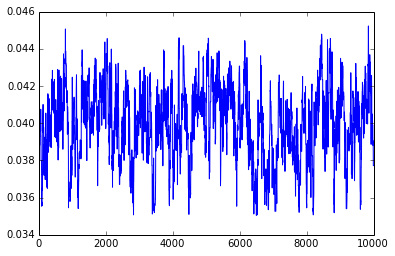

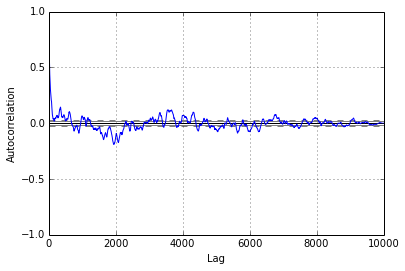

In [56]:
burn = 0
thin = 1
thinned_burned = samples[burn::thin]
plt.plot(thinned_burned)
print(np.mean(thinned_burned))
plt.figure()

autocorrelation_plot(thinned_burned)

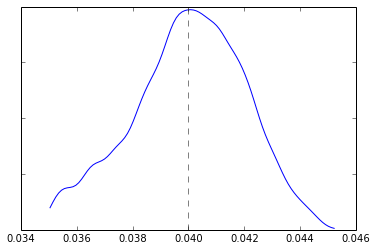

In [57]:
import scipy.stats
kde = scipy.stats.gaussian_kde(samples.T)
range = np.linspace(samples.min(), samples.max(), 100)
plt.plot(range, kde(range))
plt.axvline(0.04, color='gray', linestyle='--')
plt.gca().set_yticklabels([])
f = plt.gcf()
f.patch.set_alpha(0.0)
plt.savefig('ac_delta.pdf',  bbox_inches='tight')
#plt.hist(samples, 50);

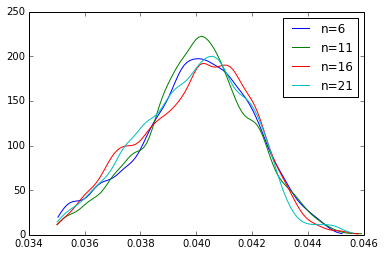

In [59]:
for n in [6, 11, 16, 21]:
    delta = np.load('delta_n={}.npy'.format(n))
    kde = scipy.stats.gaussian_kde(delta.T)
    range = np.linspace(delta.min(), delta.max(), 100)
    plt.plot(range, kde(range), label='n={}'.format(n))
plt.legend()